Let's actually take a look at our dicoms and see what we can glean from the distribution of information across scans.

First we'll need to actually extract the information we want into a dataframe

In [1]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
from pydicom import dcmread

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [3]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [4]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

#transforms all slices in a scan in hounsfield units 
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [5]:
#transforms all slices in a scan in hounsfield units 
def ct_transformed(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [6]:
one_scan = ct_transformed(dcm_sort(train_path.ls()[19]), 0)
len(one_scan), one_scan[20:30].shape

(64, (10, 512, 512))

In [7]:
ten_slices = one_scan[20:30]

In [8]:
def plot_slices(slices, rows, columns, figsize=(20,10)):
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    for n in range(rows):
        for m in range(columns):
            ax[n, m].imshow(ten_slices[n*5 + m])

In [9]:
train_path.ls()

(#176) [Path('train/ID00232637202260377586117'),Path('train/ID00134637202223873059688'),Path('train/ID00093637202205278167493'),Path('train/ID00307637202282126172865'),Path('train/ID00364637202296074419422'),Path('train/ID00172637202238316925179'),Path('train/ID00335637202286784464927'),Path('train/ID00213637202257692916109'),Path('train/ID00392637202302319160044'),Path('train/ID00030637202181211009029')...]

Having to query into the dicom each time we want to extract out information is cumbersome -- let's just pull all the data from the dicoms we're interested in considering into a dataframe

In [10]:
%%time
scans = [dcm_sort(folder) for folder in train_path.ls()]

CPU times: user 20.8 s, sys: 11 s, total: 31.9 s
Wall time: 44.5 s


In [11]:
#ok now we have 176 lists of dicoms inside of a list
len(scans)

176

Let's initialize a dataframe of the right size -- 176 rows by X number of columns -- let's remind ourselves what's in a dicom first

In [12]:
dcm = scans[0][0]
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.121598162386088989868087504905267208491
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.121598162386088989868087504905267208491
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'TOSHIBA'
(0008, 1090) M

Just showing how we'll create lists of values we're interested in - a list of lists -- which we can simply cast into a pandas dataframe when we're done

In [13]:
meow = len(scans[0])
meow

67

In [14]:
scan_info = [meow, dcm.Rows, dcm.Columns, dcm.SliceThickness,
             dcm.PixelSpacing[0], dcm.PixelSpacing[1],
             dcm.Manufacturer]

In [15]:
scan_info

[67, 512, 512, "5.0", "0.683", "0.683", 'TOSHIBA']

In [16]:
train_df[train_df['Patient'] == dcm.PatientID].iloc[0]

Patient          ID00232637202260377586117
Weeks                                    9
FVC                                   1909
Percent                            115.431
Age                                     74
Sex                                 Female
SmokingStatus                 Never smoked
Name: 885, dtype: object

In [17]:
%%time
holder = []
for dcms in scans:
    slice_count = len(dcms)
    dcm = dcms[0]
    pat = train_df[train_df['Patient'] == dcm.PatientID].iloc[0]
    holder.append([pat['Patient'], pat['Age'], pat['Sex'],
                   pat['SmokingStatus'], slice_count, dcm.Rows,
                   dcm.Columns, dcm.SliceThickness, 
                   dcm.PixelSpacing[0], dcm.PixelSpacing[1], 
                   dcm.Manufacturer])

CPU times: user 108 ms, sys: 208 µs, total: 109 ms
Wall time: 115 ms


In [18]:
len(holder), holder[0]

(176,
 ['ID00232637202260377586117',
  74,
  'Female',
  'Never smoked',
  67,
  512,
  512,
  "5.0",
  "0.683",
  "0.683",
  'TOSHIBA'])

In [19]:
metadata = pd.DataFrame(holder, columns=['patient', 'age', 'sex',
                                         'smoking_status',
                            'num_slices', 'rows', 'columns', 
                              'slice_thickness', 'spacing_x', 
                              'spacing_y', 'manufacturer'])

In [20]:
type(metadata['spacing_y'][0]), type(metadata['manufacturer'][0])

(numpy.float64, str)

In [21]:
metadata.head()

,patient,age,sex,smoking_status,num_slices,rows,columns,slice_thickness,spacing_x,spacing_y,manufacturer
0,ID00232637202260377586117,74,Female,Never smoked,67,512,512,5.0,0.683000,0.683000,TOSHIBA
1,ID00134637202223873059688,67,Male,Ex-smoker,451,512,512,1.0,0.740234,0.740234,Philips
2,ID00093637202205278167493,69,Male,Ex-smoker,37,512,512,1.0,0.880859,0.880859,SIEMENS
3,ID00307637202282126172865,65,Male,Never smoked,29,512,512,1.0,0.707031,0.707031,SIEMENS
4,ID00364637202296074419422,64,Male,Ex-smoker,33,512,512,1.0,0.712891,0.712891,SIEMENS


Pandas did the work for us to cast things that look like numerical values as such! :)

We could of course create a function of the above and choose what values to pass, or set some defaults but allow for it to add additional values if desired -- it would also send it into the dataframe and return that

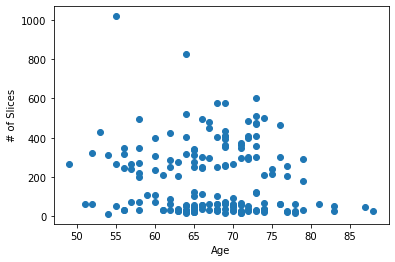

In [22]:
plt.scatter(metadata.age, metadata.num_slices)
plt.ylabel('# of Slices')
plt.xlabel('Age');

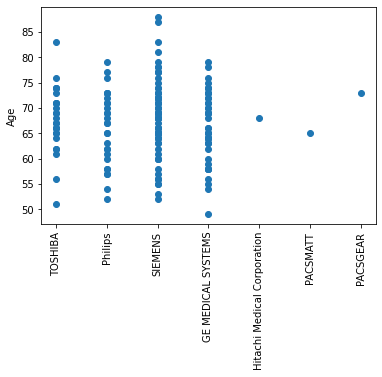

In [23]:
plt.scatter(metadata.manufacturer, metadata.age)
plt.xticks(rotation=90)
plt.ylabel('Age');

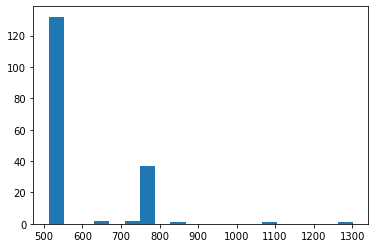

In [24]:
plt.hist(metadata['rows'], bins=20);

In [25]:
metadata['rows'].value_counts()

512     132
768      34
752       2
632       2
734       1
733       1
1100      1
843       1
1302      1
788       1
Name: rows, dtype: int64

In [26]:
metadata['columns'].value_counts()

512     132
768      34
888       7
632       2
1302      1
Name: columns, dtype: int64

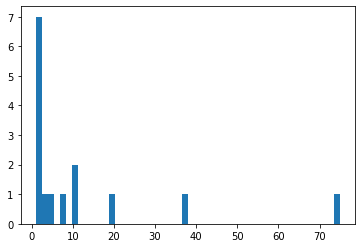

In [27]:
plt.hist(metadata['slice_thickness'].value_counts(), bins=50);

Now we know that some of our images don't have the same shape across both dimensions

The little noise below is simply checking if the spacing is the same in both direction. Since it returns true, we flip and it and sum the value. If it adds up to zero, that means everything matched up

In [28]:
(~(metadata['spacing_x'] == metadata['spacing_y'])).sum()

0

In [29]:
(~(metadata['rows'] == metadata['columns'])).sum()

7

So 7 samples have rectangular slices vs squared

Let's also add some less obvious information

In [30]:
%%time
holder = []
for dcms in scans:
    slice_count = len(dcms)
    dcm = dcms[0]
    pat = train_df[train_df['Patient'] == dcm.PatientID].iloc[0]
    holder.append([pat['Patient'], pat['Age'], pat['Sex'],
                   pat['SmokingStatus'], slice_count, dcm.Rows, 
                   dcm.Columns, dcm.SliceThickness, 
                   dcm.PixelSpacing[0], dcm.PixelSpacing[1], 
                   dcm.Manufacturer, dcm.KVP, 
                   dcm.ConvolutionKernel,dcm.PatientPosition])
    
metadata = pd.DataFrame(holder, columns=['patient', 'age',
                                         'sex', 'smoking_status',
                                'num_slices', 'rows', 'columns', 
                              'slice_thickness', 'spacing_x', 
                              'spacing_y', 'manufacturer',
                            'kvp', 'convolution_kernel',
                                        'patient_position'])

CPU times: user 99.7 ms, sys: 0 ns, total: 99.7 ms
Wall time: 99.1 ms


In [31]:
metadata

,patient,age,sex,smoking_status,num_slices,rows,columns,slice_thickness,spacing_x,spacing_y,manufacturer,kvp,convolution_kernel,patient_position
0,ID00232637202260377586117,74,Female,Never smoked,67,512,512,5.000,0.683000,0.683000,TOSHIBA,120.0,FC52,FFS
1,ID00134637202223873059688,67,Male,Ex-smoker,451,512,512,1.000,0.740234,0.740234,Philips,120.0,YC,HFS
2,ID00093637202205278167493,69,Male,Ex-smoker,37,512,512,1.000,0.880859,0.880859,SIEMENS,120.0,B60f,FFS
3,ID00307637202282126172865,65,Male,Never smoked,29,512,512,1.000,0.707031,0.707031,SIEMENS,110.0,B90s,HFS
4,ID00364637202296074419422,64,Male,Ex-smoker,33,512,512,1.000,0.712891,0.712891,SIEMENS,100.0,B50f,HFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,ID00336637202286801879145,56,Male,Ex-smoker,33,512,512,1.000,0.650391,0.650391,SIEMENS,120.0,B70s,FFP
172,ID00383637202300493233675,64,Female,Never smoked,32,512,512,1.000,0.656250,0.656250,SIEMENS,120.0,B50f,HFS
173,ID00067637202189903532242,64,Male,Ex-smoker,319,733,888,1.250,0.871094,0.871094,GE MEDICAL SYSTEMS,120.0,LUNG,FFS
174,ID00317637202283194142136,64,Male,Ex-smoker,521,512,512,0.625,0.677734,0.677734,GE MEDICAL SYSTEMS,120.0,LUNG,FFS


In [32]:
metadata['manufacturer'].value_counts()

SIEMENS                        74
GE MEDICAL SYSTEMS             45
Philips                        28
TOSHIBA                        26
PACSGEAR                        1
PACSMATT                        1
Hitachi Medical Corporation     1
Name: manufacturer, dtype: int64

In [33]:
#Peak kilo voltage output of xray generator used
metadata['kvp'].value_counts()

120.0    130
140.0     19
100.0     12
130.0     11
110.0      3
135.0      1
Name: kvp, dtype: int64

In [34]:
#convolution kernel used to reconstruct the data
metadata['convolution_kernel'].value_counts()

LUNG         18
B70f         17
B70s         16
BONEPLUS     13
B60f         10
BONE         10
L             9
B50f          8
C             8
B80s          8
FC86          6
FC52          5
FC51          4
FC01          4
STANDARD      4
B90s          4
YB            3
D             3
FC30          2
B60s          2
YC            2
FC53          2
B80f          2
B50s          2
FC18          1
F             1
[I50f, 3]     1
B40f          1
CHST          1
23            1
B             1
DETAIL        1
FC50          1
B30f          1
B41f          1
FC11          1
YD            1
B31f          1
Name: convolution_kernel, dtype: int64

In [35]:
metadata['patient_position'].value_counts()

HFS    85
FFS    82
FFP     7
HFP     2
Name: patient_position, dtype: int64

https://dicom.innolitics.com/ciods/ct-image/general-series/00185100<br>

https://stackoverflow.com/questions/40115444/dicom-understanding-the-relationship-between-patient-position-0018-5100-image


Ok so we have different positions of the patients, will this matter? <br> HFS: Head first supine <br> FFS: Feet first supine <br> FFP: Feet first prone <br> HFP: Head first prone

Prone means that they are on their stomaches while supine means they are on their backs. The lungs sit higher up in the torso -- so let's say you start scanning when you start either from the hips or the shoulders, the feet first approach could mean you have even more dead space in the scan than the head first approach.

1) Can we not just sort all the scans in the same way because of the patient position? Or does the scanners algorithm take care to flip/invert the scans? Unlikely <br>
2) Is there a discrepency in outcomes based on the patient position? We'll need to reference the train_df information to analyze this!

In [36]:
slice_position = metadata[['num_slices', 'patient_position']]
slice_position.head()

,num_slices,patient_position
0,67,FFS
1,451,HFS
2,37,FFS
3,29,HFS
4,33,HFS


In [37]:
slice_position.sort_values(by=['num_slices'])

,num_slices,patient_position
55,12,FFP
126,16,FFS
129,17,FFP
31,17,FFS
50,18,FFS
...,...,...
52,574,HFS
97,577,HFS
87,602,HFS
21,825,FFS


In [38]:
hfs = slice_position[slice_position['patient_position'] == 'HFS'].reset_index()
hfs['num_slices'].median(), hfs['num_slices'].mean()

(178.0, 199.72941176470587)

In [39]:
ffs = slice_position[slice_position['patient_position'] == 'FFS']
ffs['num_slices'].median(), ffs['num_slices'].mean()

(74.0, 184.4268292682927)

In [40]:
hfp = slice_position[slice_position['patient_position'] == 'HFP']
hfp['num_slices'].median(), hfs['num_slices'].mean()

(119.5, 199.72941176470587)

In [41]:
ffp = slice_position[slice_position['patient_position'] == 'FFP'].reset_index()
ffp['num_slices'].median(), ffp['num_slices'].mean()

(29.0, 98.14285714285714)

In [42]:
manuf_slices = metadata[['num_slices', 'manufacturer']]
manuf_slices.head()

,num_slices,manufacturer
0,67,TOSHIBA
1,451,Philips
2,37,SIEMENS
3,29,SIEMENS
4,33,SIEMENS


In [43]:
manuf_info = []
for manufac in list(metadata['manufacturer'].unique()):
    man_iso = manuf_slices[manuf_slices['manufacturer'] == manufac]
    mean, median = man_iso.mean().item(), man_iso.median().item()
    manuf_info.append([manufac, median, mean, len(man_iso)])

In [44]:
manuf_df = pd.DataFrame(manuf_info, columns=['manufacturer', 'median', 'mean',
                                 'unique_scans'])
manuf_df

,manufacturer,median,mean,unique_scans
0,TOSHIBA,77.0,219.346154,26
1,Philips,280.5,255.642857,28
2,SIEMENS,65.0,153.554054,74
3,GE MEDICAL SYSTEMS,71.0,188.822222,45
4,Hitachi Medical Corporation,253.0,253.000000,1
5,PACSMATT,24.0,24.000000,1
6,PACSGEAR,28.0,28.000000,1


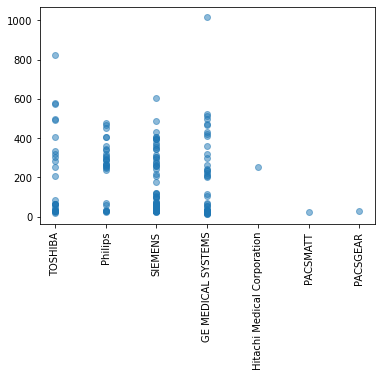

In [45]:
plt.scatter(manuf_slices['manufacturer'], manuf_slices['num_slices'],
           alpha=0.5)
plt.xticks(rotation=90);

In [46]:
metadata.head()

,patient,age,sex,smoking_status,num_slices,rows,columns,slice_thickness,spacing_x,spacing_y,manufacturer,kvp,convolution_kernel,patient_position
0,ID00232637202260377586117,74,Female,Never smoked,67,512,512,5.0,0.683000,0.683000,TOSHIBA,120.0,FC52,FFS
1,ID00134637202223873059688,67,Male,Ex-smoker,451,512,512,1.0,0.740234,0.740234,Philips,120.0,YC,HFS
2,ID00093637202205278167493,69,Male,Ex-smoker,37,512,512,1.0,0.880859,0.880859,SIEMENS,120.0,B60f,FFS
3,ID00307637202282126172865,65,Male,Never smoked,29,512,512,1.0,0.707031,0.707031,SIEMENS,110.0,B90s,HFS
4,ID00364637202296074419422,64,Male,Ex-smoker,33,512,512,1.0,0.712891,0.712891,SIEMENS,100.0,B50f,HFS


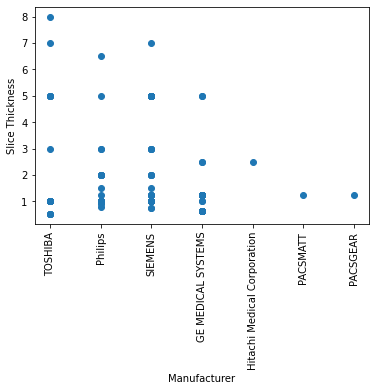

In [47]:
plt.scatter(metadata['manufacturer'], metadata['slice_thickness'])
plt.xlabel('Manufacturer')
plt.ylabel('Slice Thickness')
plt.xticks(rotation=90);

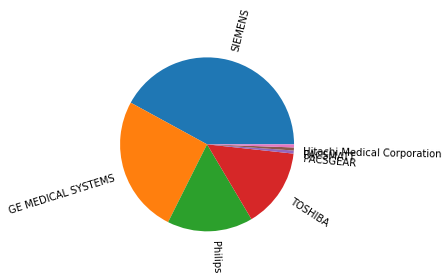

In [71]:
plt.pie(metadata['manufacturer'].value_counts(), 
       labels=list(metadata['manufacturer'].value_counts().index),
       rotatelabels=60);

In [72]:
#to make sure that the labeling was done correctly
metadata['manufacturer'].value_counts()

SIEMENS                        74
GE MEDICAL SYSTEMS             45
Philips                        28
TOSHIBA                        26
PACSGEAR                        1
PACSMATT                        1
Hitachi Medical Corporation     1
Name: manufacturer, dtype: int64

Kind of hard to see the labels -- a legend would be better

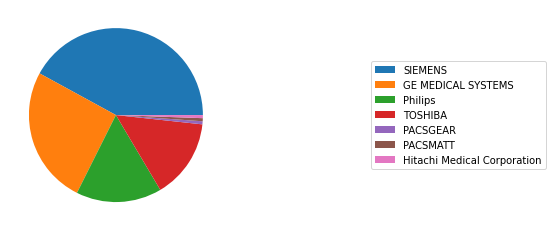

In [103]:
plt.pie(metadata['manufacturer'].value_counts(), labeldistance=None,
       labels=list(metadata['manufacturer'].value_counts().index));
plt.legend(loc='right', bbox_to_anchor=(1,0,1.5,1));

In [104]:
plt.bar(metadata['manufacturer'].value_counts())

TypeError: bar() missing 1 required positional argument: 'height'

In [92]:
wedges

In [48]:
def scatter_plot(x_val, y_val, title=None, rotation=None):
    plt.scatter(metadata[x_val], metadata[y_val], alpha=0.5)
    if rotation:
        plt.xticks(rotation=rotation)
    if title:
        plt.title(title)
    plt.ylabel(y_val)
    plt.xlabel(x_val);

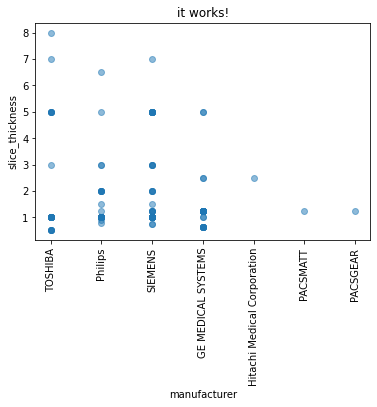

In [49]:
scatter_plot('manufacturer', 'slice_thickness', 'it works!', 90)

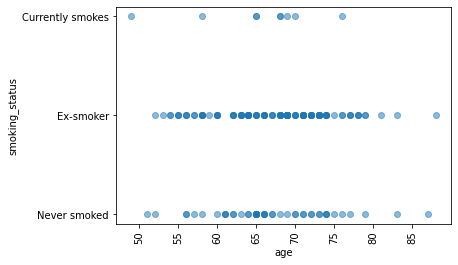

In [50]:
scatter_plot('age', 'smoking_status', rotation=90)

In [51]:
metadata.columns.T

Index(['patient', 'age', 'sex', 'smoking_status', 'num_slices', 'rows',
       'columns', 'slice_thickness', 'spacing_x', 'spacing_y', 'manufacturer',
       'kvp', 'convolution_kernel', 'patient_position'],
      dtype='object')

Let's extract the same information for the tets set and then actually compare discrepencies between train & test

Also need to try out different plots -- lol